# Figure 1
- Concentration is scaled by 2.5. to bring the background concentration to 1ug/L

## Caption
Maximum concentration (in μg/L), 2007-2010 average summer. The 11 rivers are marked and segregated in to North, East, and West groups. The watershed is shaded in dark gray with sub-basins delineated by hydrologic unit codes. The near-shore zone is delineated using the 30 m depth contour (gray), the definition used by National Coastal Conditions Assessment. 

In [1]:
%matplotlib inline


import numpy as np
import xarray as xr
import pandas as pd
import cmocean
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.io import shapereader
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

### set de-fault san-sserif to helvetica
#mpl.rcParams['font.sans-serif'] = 'Helvetica'
### ALWAYS use sans-serif fonts
mpl.rcParams['font.family'] = 'sans-serif'
### So can edit ina Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## 1 .Load data

In [2]:
%run _load_directories.ipynb

DIRECTORIES
>> {dir_raw}
/local/data/artemis/workspace/gloege/MITgcm-Michigan-Phosphorus/data/raw

>> {dir_clean}
/local/data/artemis/workspace/gloege/MITgcm-Michigan-Phosphorus/data/clean

>> {dir_figs}
/local/data/artemis/workspace/gloege/MITgcm-Michigan-Phosphorus/results/figures


# load data
scaled by the concentration by 2.5 to bring background concentraiton from all rivers up to 1ug/L

In [3]:
ds_jja = xr.open_dataset(f'{dir_clean}/phosphorus_max_JJA.nc') 

## 2. Plot data

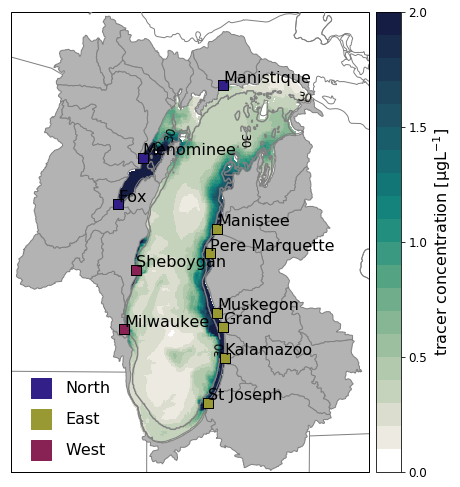

In [5]:
### ==============================================================
### Define grids
### ==============================================================
fig = plt.figure(figsize=(7,11))

projection = ccrs.Mercator()
axes_class = (GeoAxes, dict(map_projection=projection))
grid = AxesGrid(fig, 111, axes_class=axes_class,
                share_all=False,
                nrows_ncols = (1, 1),
                axes_pad = 0.2,
                cbar_location = 'right',
                cbar_mode="edge",
                cbar_pad = 0.1,
                cbar_size = '7%',
                label_mode = '')  # note the empty label_mode
### should really change ax to grid[0] everywhere
ax=grid[0]

### ==============================================================
### Set boundaries
### ==============================================================
#ax.set_extent([-84.75, -88.25, 41.5, 46.25]) ### Michigan
ax.set_extent([-89.8, -83.8, 41.25, 46.8])    ### Watershed

### ==============================================================
### Colormap of data
### ============================================================== 
# define the colormap
vmin = 0
vmax = 2
cmap = cmocean.cm.tempo
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1,1,1,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(vmin,vmax,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

pos = ax.pcolormesh(ds_jja['X'].values, ds_jja['Y'].values, 
          ds_jja['phos_max_JJA'].where(ds_jja['phos_max_JJA']>0).values, 
           cmap = cmap, 
           norm = norm,
           vmin = vmin, 
           vmax = vmax,
           transform=ccrs.PlateCarree(),
           zorder = 2)

### ==============================================================
### Create a feature for States/Admin 1 
### regions at 1:50m from Natural Earth
### ==============================================================
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', facecolor='none')


### ==============================================================
### Create a feature for lakes at 1:50m from Natural Earth
### ==============================================================
lakes_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='10m',
    facecolor='none')
ax.add_feature(lakes_50m, edgecolor=(0.5,0.5,0.5), facecolor='none', zorder=3)


### ==============================================================
### Plot Lake Michigan watershed
### ==============================================================
### Unit names (if I want to color these differently)
UNITNAME=['Muskegon','Lower Fox','Lower Grand','Kalamazoo','St. Joseph','Manistique'
,'Menominee','Manistee','Pere Marquette-White','Milwaukee','Manitowoc-Sheboygan']

### reads HUC 8 subbasins
watershed_shp = f'{dir_data}/shapefiles/glwsheds/glwsheds.shp'
reader = shapereader.Reader(watershed_shp)
lakes = reader.records()

### plot HUC 8 subbasins. 
### The commented out bits help color by UNITNAMEs
### Nothing was really gains by coloring those watersheds
for lake in lakes:
    if lake.attributes['LAKEBASIN'] == 'Michigan':
#       if lake.attributes['UNITNAME'] in UNITNAME:
        ax.add_geometries(lake.geometry, 
                              ccrs.PlateCarree(), 
                              facecolor=(0.7, 0.7, 0.7),
                              edgecolor=(0.5, 0.5, 0.5),
                              linewidths=1.,
                              label=lake.attributes['LAKEBASIN'], zorder=4) 
#        else:
#            ax.add_geometries(lake.geometry, 
#                  ccrs.PlateCarree(), 
#                  facecolor=(0.87, 0.87, 0.87),
#                  edgecolor=(0.5, 0.5, 0.5),
#                  linewidths=1.,
#                  label=lake.attributes['LAKEBASIN'], zorder=4) 
### ==============================================================
### Add 30m contour
### ==============================================================
grid_nc = f'{dir_raw}/grid_lake_michigan.nc'
ds_grid = xr.open_dataset(grid_nc, mask_and_scale=True)
cs = ax.contour(ds_grid['X'].values, ds_grid['Y'].values, ds_grid['Depth'].values, 
                levels=[30],
                colors=((0.5, 0.5, 0.5), (1, 1, 1)),
                transform=ccrs.PlateCarree(), 
                zorder=2)
ax.clabel(cs, inline=True, fmt='%1.0f', fontsize=12, colors='k')


### ==============================================================
### Add river mouth
### ==============================================================
rivers_list=['Milwaukee', 'Sheboygan', 'Fox', 'Menominee', 
             'Manistique', 'Manistee', 'Pere Marquette', 'Muskegon', 
             'Grand', 'Kalamazoo', 'St Joseph']

### River colors
N_col = list(map(lambda x: x / 255, [51, 31, 136]))
SE_col = list(map(lambda x: x / 255, [153, 153, 51]))
SW_col = list(map(lambda x: x / 255, [136, 34, 85]))
river_cols = [SW_col, SW_col, N_col, N_col, N_col, 
              SE_col, SE_col, SE_col, SE_col, SE_col, SE_col]

### Read rivers plot locations
csv_rivers_LM = f'{dir_raw}/wrtds_LM_stations.csv'   
df = pd.read_csv(csv_rivers_LM, index_col=0).loc[rivers_list, :]
ax.scatter(df['lonMouth'].values, df['latMouth'].values,
              s=100,
              c=river_cols,
              marker='s',
              alpha=1,
              edgecolors='k',
              linewidths=1,
              transform=ccrs.PlateCarree(),
              zorder=5)

### ==============================================================
### Add river mouth labels
### ==============================================================
df = pd.read_csv(csv_rivers_LM)
df = df[df['river'].isin(rivers_list)]
for ln, lt, lb in zip(df['lonMouth'].values, df['latMouth'].values, df['river']):
    ax.text(ln, lt, lb,
             fontsize=16,
            fontweight='medium',
             #fontweight=10,
             ha='left',
             va='bottom',
             color='k',
             transform=ccrs.PlateCarree(),
             zorder=5)  

### ==============================================================
### Add a legend
### ==============================================================
north = ax.scatter(-999, -999, 
          s=1, 
          c=N_col, 
          marker='s', 
          label='North')
southEast = ax.scatter(-999, -999, 
          s=1, 
          c=SE_col, 
          marker='s', 
          label='East')
southWest = ax.scatter(-999, -999, 
          s=1, 
          c=SW_col, 
          marker='s', 
          label='West')

### Controls North, East, West legend
ax.legend(handles=[north, southEast, southWest], 
          loc=3, 
          fontsize=16, 
          markerscale=20, 
          handletextpad=0.5, 
          labelspacing=1,
          frameon=False)

### ==============================================================
### Add colorbar
### Better to use plt with reference to cax 
### than to grid.cbar_axes[0].colorbar(sub)
### since it is clunky as all get
### ==============================================================
cbar = plt.colorbar(pos, cax=grid.cbar_axes[0])
cbar.set_label(r'tracer concentration [$\rm \mu g L^{-1}$]', fontsize=16)
cbar.set_ticks(np.arange(0, 2.2, 0.5))
cbar.ax.tick_params(labelsize=12) 


In [6]:
fig.savefig(f'{dir_figs}/Figure_1.pdf', bbox_inches='tight',pad_inches=0)